# Your first CNN on CIFAR-10

In this programming assignment you will: 
- define your first CNN architecture for CIFAR-10 dataset
- train it from scratch
- visualize learnt filters

CIFAR-10 dataset contains 32x32 color images from 10 classes: __airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck__:

<img src="https://github.com/hse-aml/intro-to-dl-pytorch/blob/main/week03/images/cifar10.jpg?raw=1" style="width:80%">

In [ ]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import random
import tqdm
import itertools
import collections
from copy import deepcopy
from IPython import display

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets, transforms

In [ ]:
#auxiliary stuff
def calculate_accuracy(prediction, target):
    # Note that prediction.shape == target.shape == [B, ]
    
    matching = (prediction == target).float()
    return matching.mean()

class AverageMeter:
    
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# CIFAR-10 dataset

Set up datasets:

In [ ]:
# Convert from PIL to torch.Tensort
# and normalize each pixel from [0, 255] range to [0.0, 1.0]
base_transforms = transforms.ToTensor()

# An augmentation that randomly (with a probability equal to 0.5)
# flips the image horizontally
# This will prevent overfitting and make the model more robust
aug_transforms = transforms.RandomHorizontalFlip(p=0.5)

# Gather all transforms together
train_transforms = transforms.Compose([
    base_transforms,
    aug_transforms
])

train_dataset = datasets.CIFAR10('./', train=True, download=True, transform=train_transforms)

# Note that we only use `base_transforms` for test dataset
test_dataset = datasets.CIFAR10('./', train=False, download=True, transform=base_transforms)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


Let's look at a batch of random train images:

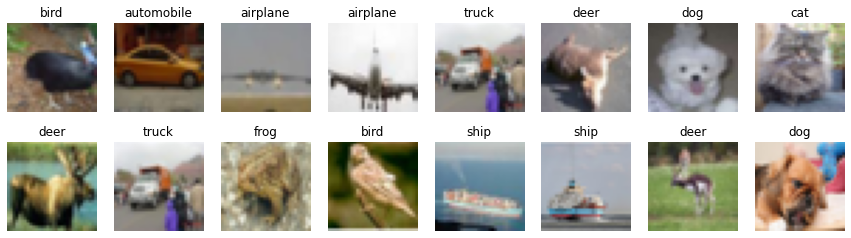

In [ ]:
index2class = {v: k for k, v in train_dataset.class_to_idx.items()}

cols = 8
rows = 2

fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))

for i in range(cols):
    for j in range(rows):
        random_index = random.randint(0, len(train_dataset) - 1)
        
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        
        image, label = train_dataset[random_index]
        
        # move the channel dimension to the end
        images = image.permute(1, 2, 0)
        
        ax.imshow(images)
        ax.set_title(index2class[label])

plt.show()

As usual, let's wrap our datasets in data dataloaders

In [ ]:
BATCH_SIZE = 32

# `pin_memory` speed up processing if you use GPU
# `num_workers` also speed up processing since use additional process
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                              num_workers=0, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                             num_workers=0, pin_memory=True)

# CNN architecture

Convolutional networks are built from several types of layers:
- [Conv2D](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) - performs convolution:
- [MaxPool2d](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) - performs 2D max pooling.
- [Flatten](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html) - flattens the input, does not affect the batch size.
- [Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) - fully-connected layer.
- [LeakyReLU](https://pytorch.org/docs/stable/generated/torch.nn.LeakyReLU.html) - applies leaky relu activation.
- [Dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) - applies dropout.

Feel free to learn official documentation about other basic building blocks: https://pytorch.org/docs/stable/nn.html

You need to define a model which takes __(None, 32, 32, 3)__ input and predicts __(None, 10)__ output with probabilities for all classes. __None__ in shapes stands for batch dimension.

Simple feed-forward networks in PyTorch can be defined in the following way:

```python
model = nn.Sequential()  # start feed-forward model definition
model.add_module('block_name', nn.Conv2d(in_channels=..., out_channels=..., kernel_size=...))

...  # here comes a bunch of convolutional, pooling and dropout layers

model.add_module('block_name', nn.Linear(in_features=..., out_features=...))  # the last layer with a neuron for each class
```

Or you can immediately define layers within `nn.Sequential`:

```python
model = nn.Sequential(
    nn.Conv2d(in_channels=..., out_channels=..., kernel_size=...),
    nn.LeakyReLU(...),
    # and so on
)
```

### Architecture details
Stack __4__ convolutional layers with kernel size __(3, 3)__ with growing number of filters __(16, 32, 32, 64)__.
Don't forget to add `padding` argument to each convolutional layers so that the shape of the image is not reduced.
Try to figure out what size padding is needed for each dimension (height and width).

Add __2x2__ pooling layer after every 2 convolutional layers (conv-conv-pool scheme).

Use __LeakyReLU__ activation with recommended parameter __0.1__ for all layers that need it (after convolutional and linear layers):
```python
model.append(nn.LeakyReLU(0.1))
```

Add a __Linear__ layer with __256__ output neurons and a second __Linear__ layer with __10__ neurons for classes.
Remember to use __Flatten__ layer before first dense layer to reshape input volume into a flat vector!

Add __Dropout__ after every pooling layer (__0.25__) and between __Linear__ layers (__0.5__).

In [ ]:
def make_model():
    """
    Define your model architecture here.
    Returns `Sequential` model.
    """
    
    #input batches [batch, 32, 32, 3]
    model = nn.Sequential(
        # define layers
        nn.Conv2d(3, 16, kernel_size=(3,3), padding='same'),
        nn.LeakyReLU(0.1),

        nn.Conv2d(16, 32, kernel_size=(3,3), padding='same'),
        nn.LeakyReLU(0.1),
        
        nn.MaxPool2d((2,2)),
        nn.Dropout(0.25),


        nn.Conv2d(32, 32, kernel_size=(3,3), padding='same'),
        nn.LeakyReLU(0.1),
        nn.Conv2d(32, 64, kernel_size=(3,3), padding='same'),
        nn.LeakyReLU(0.1),

        nn.MaxPool2d((2,2)),
        nn.Dropout(0.25),



        nn.Flatten(),
        nn.Linear(4096,256),
        nn.Dropout(0.25),
        nn.LeakyReLU(0.1),
        nn.Linear(256, 10)
        

        ### YOUR CODE HERE ###
    )
    
    # Don't add Softmax or something else to the end!
    # We will use nn.CrossEntropyLoss which does this itself.
    
    return model

In [ ]:
model = make_model()

In [ ]:
def get_num_parameters(model):
    return sum(p.numel() for p in model.parameters())

In [ ]:
assert get_num_parameters(model) > 1_000_000, 'Oops, make sure you did everything according to instruction'

In [ ]:
#answer!
q1 = get_num_parameters(model)
q1

1084234

# Train the model

During training you should observe the decrease in reported loss on training and test. If the loss on training is not decreasing with epochs you should revise your model definition and learning rate.

In [ ]:
NUM_EPOCH = 50
DEVICE = torch.device('cuda:0')
HISTORY = collections.defaultdict(list)

model = make_model().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.9, nesterov=True)

# Set up learning rate scheduler
# This will speed up the convergence of the model
lr_scheduler = optim.lr_scheduler.MultiStepLR(
    optimizer=optimizer,
    milestones=[20, 40],
    gamma=0.1,
    verbose=True
)

Adjusting learning rate of group 0 to 1.0000e-02.


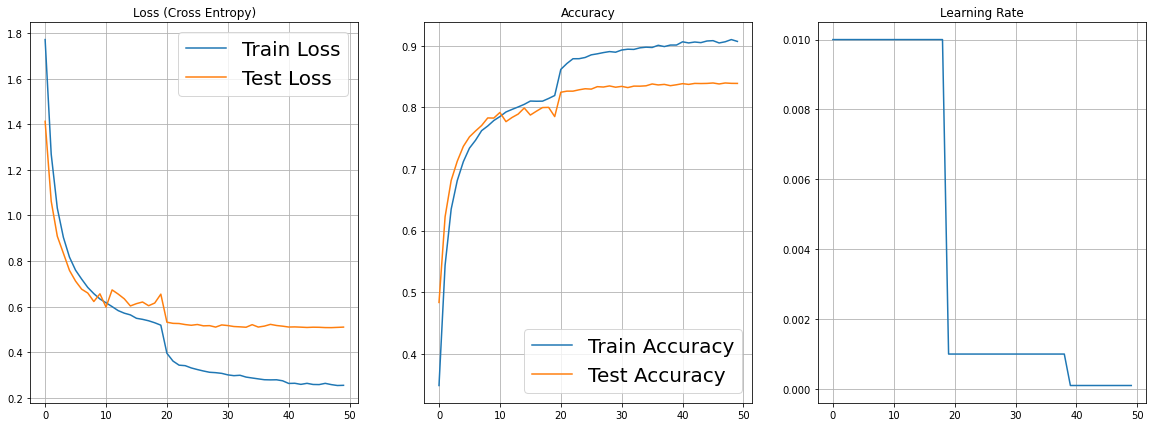

In [ ]:
for epoch in range(NUM_EPOCH):
    # AverageMeter will accumulate average of some metric
    train_loss_meter = AverageMeter()
    train_accuracy_meter = AverageMeter()
    test_loss_meter = AverageMeter()
    test_accuracy_meter = AverageMeter()
    
    # training loop
    # sets the module in training mode -- it is important for nn.Dropout
    model.train()
    # wrap `train_dataloader` within tqdm to visualize progress
    for train_batch in tqdm.tqdm(train_dataloader):
        
        # unpack batch and move to specific device (for example, GPU or TPU)
        images, labels = train_batch
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        
        # do forward pass
        logits = model(images)
        prediction = logits.argmax(dim=-1)
        
        # calculate loss (CrossEntropy)
        loss = criterion(logits, labels)
        
        # zero out the previous gradients of our model parameters
        optimizer.zero_grad()
        
        # calculate new gradients
        loss.backward()
        
        # do optimization step
        optimizer.step()
        
        # calculate current average loss and accuracy
        train_loss_meter.update(loss.item())
        train_accuracy_meter.update(
            calculate_accuracy(
                prediction.detach(),
                labels
            ).item()
        )
    
    # update lr_scheduler
    lr_scheduler.step()
        
    # save average train loss and accuracy
    HISTORY['train_loss'].append(train_loss_meter.avg)
    HISTORY['train_accuracy'].append(train_accuracy_meter.avg)
    
    # lr_scheduler.get_last_lr() return list of LRs (one LR for each group)
    HISTORY['learning_rate'].append(lr_scheduler.get_last_lr()[0])
        
    # testing loop
    # sets the module in evaluation mode
    model.eval()
    for test_batch in test_dataloader:
        images, labels = test_batch
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        
        # аdd `with torch.no_grad()' to avoid computing gradients of weights
        with torch.no_grad():
            # do everything like we did in training loop
            logits = model(images)
            prediction = logits.argmax(dim=-1)
            loss = criterion(logits, labels)
        
        test_loss_meter.update(loss.item())
        test_accuracy_meter.update(
            calculate_accuracy(
                prediction,
                labels
            ).item()
        )
    
    # save average test accuracy loss and accuracy
    HISTORY['test_loss'].append(test_loss_meter.avg)
    HISTORY['test_accuracy'].append(test_accuracy_meter.avg)
    
    # visualize all togather
    display.clear_output()
    fig, axes = plt.subplots(1, 3, figsize=(20, 7))
    
    axes[0].set_title('Loss (Cross Entropy)')
    axes[0].plot(HISTORY['train_loss'], label='Train Loss')
    axes[0].plot(HISTORY['test_loss'], label='Test Loss')
    axes[0].grid()
    axes[0].legend(fontsize=20)
    
    axes[1].set_title('Accuracy')
    axes[1].plot(HISTORY['train_accuracy'], label='Train Accuracy')
    axes[1].plot(HISTORY['test_accuracy'], label='Test Accuracy')
    axes[1].grid()
    axes[1].legend(fontsize=20)
    
    axes[2].set_title('Learning Rate')
    axes[2].plot(HISTORY['learning_rate'])
    axes[2].grid()
    
    plt.show()
        

In [ ]:
torch.save(model.state_dict(), 'model_weights.pt')

In [ ]:
weights = torch.load('model_weights.pt', map_location=DEVICE)
model = make_model().to(DEVICE)
model.load_state_dict(weights)

<All keys matched successfully>

# Evaluate the model

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
ground_truth = []
predictions = []

model.eval()
for test_batch in test_dataloader:
    images, labels = test_batch
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    with torch.no_grad():
        logits = model(images)
        prediction = logits.argmax(dim=-1).cpu()
    
    ground_truth.append(labels.cpu())
    predictions.append(prediction)

# concatenate tensors into one
ground_truth = torch.cat(ground_truth).numpy()
predictions = torch.cat(predictions).numpy()

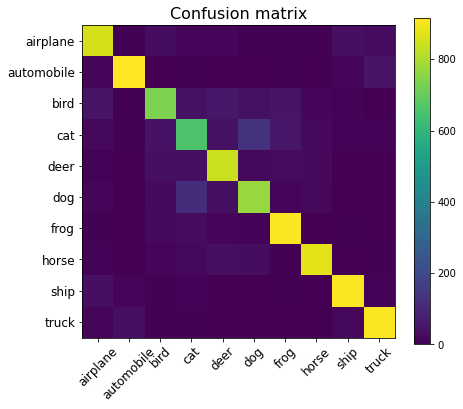

In [ ]:
plt.figure(figsize=(7, 6))
plt.title('Confusion matrix', fontsize=16)
plt.imshow(
    confusion_matrix(
        ground_truth,
        predictions
    )
)
plt.xticks(np.arange(10), train_dataset.classes, rotation=45, fontsize=12)
plt.yticks(np.arange(10), train_dataset.classes, fontsize=12)
plt.colorbar()
plt.show()

In [ ]:
#answer!
from sklearn.metrics import accuracy_score
q2 = accuracy_score(ground_truth, predictions)

In [ ]:
q2

0.8389

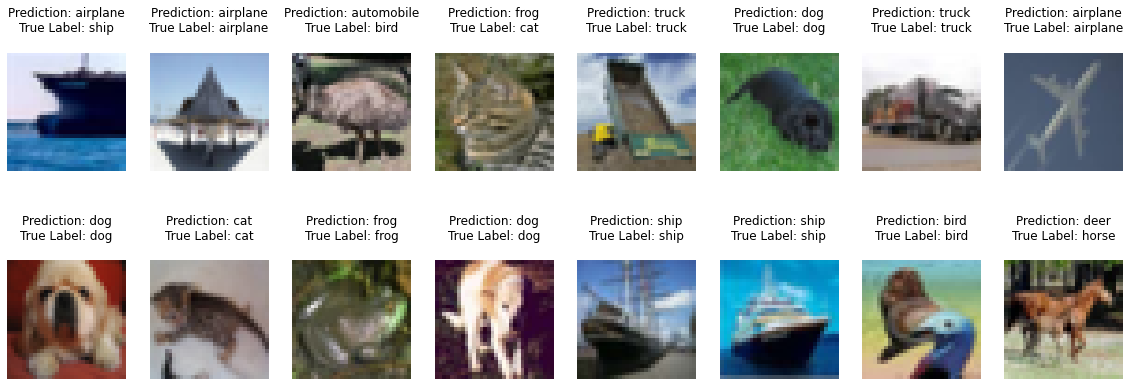

In [ ]:
# inspect preditions
fig = plt.figure(figsize=(20, 7))

for i in range(cols):
    for j in range(rows):
        
        random_index = random.randint(0, len(test_dataset) - 1)
        
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        
        image, label = test_dataset[random_index]
        
        # move the channel dimension to the end
        images = image.permute(1, 2, 0)
        
        ax.imshow(images)
        ax.set_title(f"Prediction: {index2class[predictions[random_index].item()]}\n"
                     f"True Label: {index2class[label]}\n")
plt.show()

# Visualize maximum stimuli

https://arxiv.org/pdf/1506.06579.pdf

We want to find input images that provide maximum activations for particular layers of our network. 

We will find those maximum stimuli via gradient ascent in image space.

For that task we load our model weights, calculate the layer output gradient with respect to image input and shift input image in that direction.

In [ ]:
def freeze_weights(model):
    for p in model.parameters():
        p.requires_grad_(False)

def image2rgb(image):
    # normalize image so that mean is 0 and std 0.25
    # don't forget to add eps(1e-7) to denominator
    mean, std = image.mean(), image.std()

    # # YOUR CODE HERE
    x = (image - mean) / (std + 1e-7)
    # # do reverse normalization to RGB values: x = (x_norm + 0.5) * 255
    x = (x + 0.5) * 255
    # # YOUR CODE HERE
    
    # clip values to [0, 255] and convert to bytes
    x = torch.clamp(x, 0, 255) \
        .squeeze(0) \
        .permute(1, 2, 0) \
        .byte()
    
    return x

def find_maximum_stimuli(
    model: nn.Module,
    layer_index: int,
    filter_index: int,
    step_size: float = 0.1,
    input_size: list = (32, 32),
    iterations: int = 1,
    verbose: bool = True
):
    layer = model[layer_index]
    
    if get_num_parameters(layer) == 0:
        raise ValueError(f"{layer} don't have trainable parameters!")
    
    is_conv = True if isinstance(layer, nn.Conv2d) else False
    
    new_model = model[:layer_index + 1]
    freeze_weights(new_model)
    
    # sampled from Uniform[0, 1]
    image = torch.rand(1, 3, *input_size).to(DEVICE)
    image = (image - 0.5) * (0.1 if is_conv else 0.001)
    
    # ensure gradient will be computed
    image.requires_grad_(True)
    
    for i in range(iterations):
        feature_map = new_model(image)
        
        if is_conv:
            loss = feature_map[:, filter_index].mean()
        else:
            loss = feature_map[:, filter_index].mean()
        
        loss.backward()
        
        grad = image.grad
        # change only the values of tensor (not variable)
        image.data += step_size * (grad / (torch.norm(grad) + 1e-10))
        grad.data.zero_()
        
        if verbose:
            print(f'Current loss: {loss}')
            
    return image2rgb(image.detach()).cpu(), loss.detach().cpu()

In [ ]:
def plot_filters_stimuli(
    model: nn.Module,
    layer_index: int,
    iterations=20,
    step_size=1.,
    verbose=False
):
    cols = 8
    rows = 2
    filter_index = 0
    
    # expecting that `model[layer_index]` is nn.Conv or nn.Linear
    max_filter_index = model[layer_index].weight.shape[0] - 1
    
    fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1), dpi=100)
    
    for i in range(cols):
        for j in range(rows):
            
            if filter_index <= max_filter_index:
                ax = fig.add_subplot(rows, cols, i * rows + j + 1)
                ax.grid('off')
                ax.axis('off')
                loss = -1e20
                
                while loss < 0 and filter_index <= max_filter_index:
                    stimuli, loss = find_maximum_stimuli(
                        model=model,
                        layer_index=layer_index,
                        filter_index=filter_index,
                        step_size=step_size,
                        iterations=iterations,
                        verbose=verbose
                    )
                    
                    filter_index += 1

                if loss > 0:
                    ax.imshow(stimuli)
                    ax.set_title("Filter #{}".format(filter_index))
                
    plt.show()

# Maximum stimuli for convolutional neurons

Layer: Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
Index Layer: 0


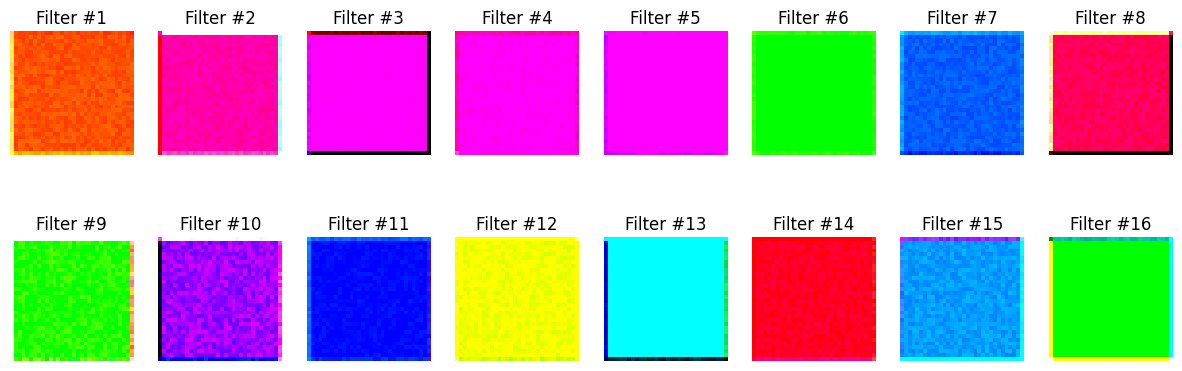

Layer: Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
Index Layer: 2


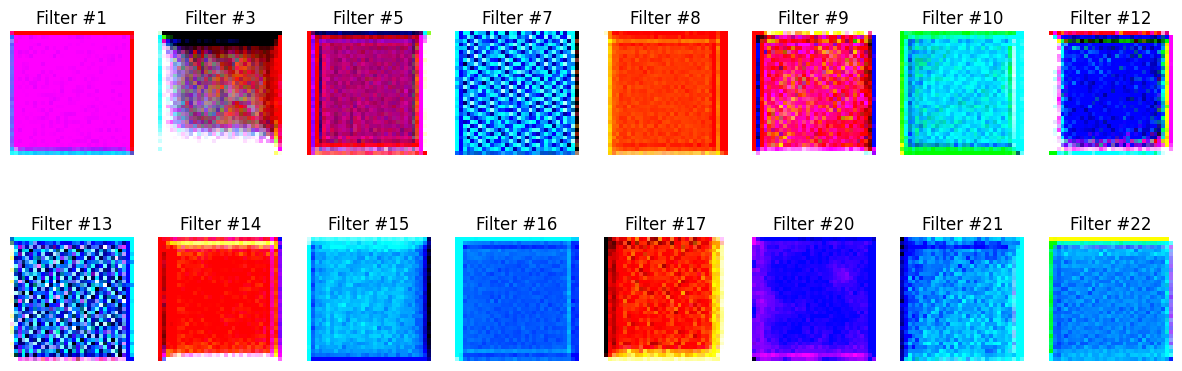

Layer: Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
Index Layer: 6


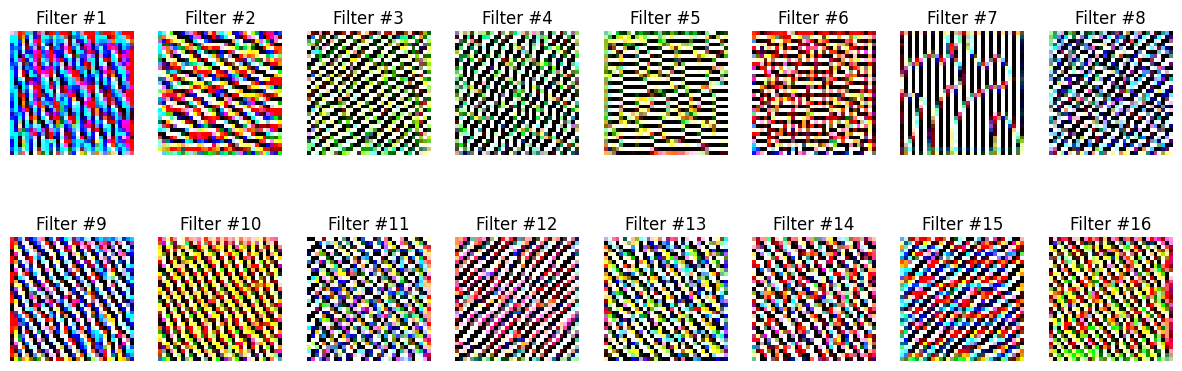

Layer: Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
Index Layer: 8


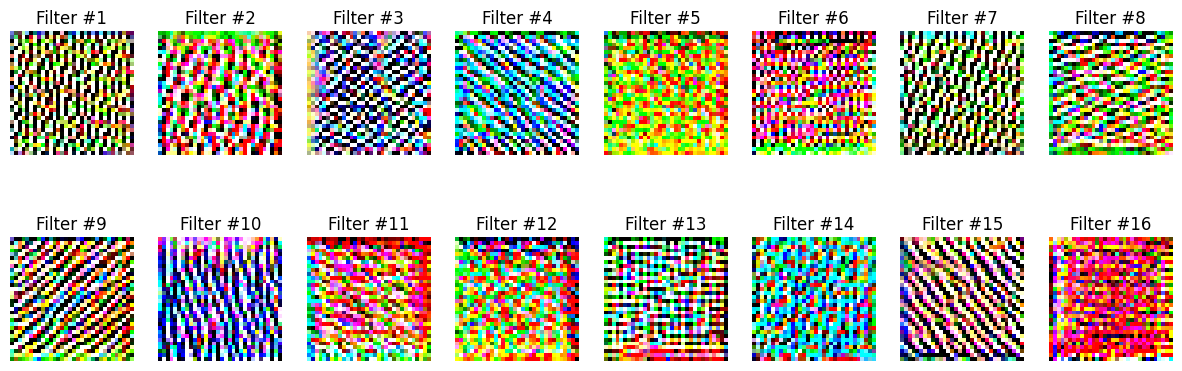

In [ ]:
for index_layer, layer in enumerate(model.children()):
    if isinstance(layer, nn.Conv2d): 
        print(
            f'Layer: {layer}\n'
            f'Index Layer: {index_layer}'
        )
        
        # play with the number of iterations and the `step_size
        # this can give you several different filters
        plot_filters_stimuli(model, index_layer, iterations=30, step_size=1.)

# Maximum stimuli for last linear layer

In [ ]:
print(train_dataset.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


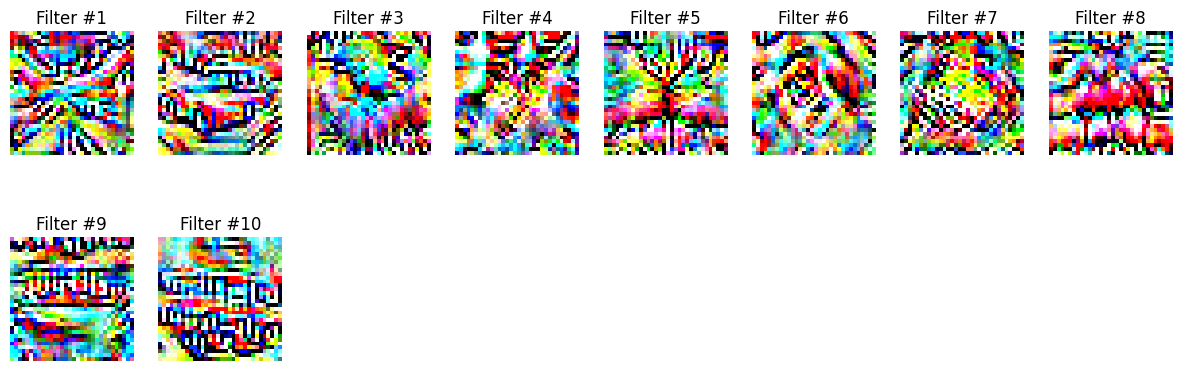

In [ ]:
plot_filters_stimuli(
    model,
    # index of last linear layer
    layer_index=16,
    iterations=200,
    step_size=0.1,
)

In [ ]:
model

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (1): LeakyReLU(negative_slope=0.1)
  (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (3): LeakyReLU(negative_slope=0.1)
  (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (5): Dropout(p=0.25, inplace=False)
  (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (7): LeakyReLU(negative_slope=0.1)
  (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (9): LeakyReLU(negative_slope=0.1)
  (10): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (11): Dropout(p=0.25, inplace=False)
  (12): Flatten(start_dim=1, end_dim=-1)
  (13): Linear(in_features=4096, out_features=256, bias=True)
  (14): Dropout(p=0.25, inplace=False)
  (15): LeakyReLU(negative_slope=0.1)
  (16): Linear(in_features=256, out_features=10, bias=True)
)

In [ ]:
def maximum_stimuli_test_for_grader():
    stimuli, loss = find_maximum_stimuli(
        model,
        layer_index=16,
        filter_index=9,
        verbose=False
    )
    return round(stimuli.float().mean().item()), round(stimuli.float().std().item())

In [ ]:
#answer!
q3 = maximum_stimuli_test_for_grader()
q3

(126, 107)

# That's it! Congratulations!

What you've done:
- defined CNN architecture
- trained your model
- evaluated your model
- visualised learnt filters